[Reference](https://medium.com/swlh/detecting-fake-news-with-python-and-machine-learning-f78421d29a06) <br>
[Text Classification](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)



In [90]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 3 08:06:15 2020

@author: Sangyun
"""

'\nCreated on Thu Sep 3 08:06:15 2020\n\n@author: Sangyun\n'

In [1]:
import re
import string

import numpy as np 
import pandas as pd
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
import nltk
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-plot
import scikitplot as skplt
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#import methods
from sklearn.naive_bayes import MultinomialNB 
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neural_network import MLPClassifier
#from xgboost import XGBClassifier

import itertools
import pandas as pd
import numpy as np
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from itertools import islice
import logging
import gensim
from gensim.models import Word2Vec

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks/')
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks


In [4]:
df = pd.read_csv("review_complexity.csv", encoding = 'latin-1')

In [5]:
# DROP DUPLICATES
df.drop_duplicates(subset=['text'], keep='first',inplace=True)
df.shape

(358081, 9)

In [6]:
df = df[:10000]
df.reset_index(inplace=True)

In [7]:
# "-1" label: Fake / "1" label: Real
df.head(10)

,index,user_id,prod_id,date,text,rating,label,length,words,complexity
0,0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,3.0,-1,40.0,"['the', 'food', 'at', 'snack', 'be', 'a', 'sel...",30.0
1,1,924,0,2013-05-16,This little place in Soho is wonderful. I had ...,3.0,-1,52.0,"['this', 'little', 'place', 'in', 'soho', 'be'...",41.0
2,2,925,0,2013-07-01,ordered lunch for 15 from Snack last Friday. Â...,4.0,-1,32.0,"['order', 'lunch', 'for', 'from', 'snack', 'la...",29.0
3,3,926,0,2011-07-28,This is a beautiful quaint little restaurant o...,4.0,-1,90.0,"['this', 'be', 'a', 'beautiful', 'quaint', 'li...",63.0
4,4,927,0,2010-11-01,Snack is great place for a Â casual sit down l...,4.0,-1,102.0,"['snack', 'be', 'great', 'place', 'for', 'a', ...",81.0
5,5,928,0,2009-09-02,A solid 4 stars for this greek food spot. Â If...,4.0,-1,41.0,"['a', 'solid', 'star', 'for', 'this', 'greek',...",34.0
6,6,929,0,2009-08-25,Let me start with a shout-out to everyone who ...,4.0,-1,133.0,"['let', 'me', 'start', 'with', 'a', 'shout', '...",98.0
7,7,930,0,2007-05-20,Love this place! Â Try the Chicken sandwich or...,4.0,-1,22.0,"['love', 'this', 'place', 'try', 'the', 'chick...",19.0
8,8,931,0,2005-12-27,My friend and I were intrigued by the nightly ...,4.0,-1,104.0,"['my', 'friend', 'and', 'i', 'be', 'intrigue',...",68.0
9,9,932,0,2014-05-09,Stopped in for lunch today and couldn't believ...,5.0,-1,45.0,"['stop', 'in', 'for', 'lunch', 'today', 'and',...",41.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       10000 non-null  int64  
 1   user_id     10000 non-null  int64  
 2   prod_id     10000 non-null  int64  
 3   date        10000 non-null  object 
 4   text        10000 non-null  object 
 5   rating      10000 non-null  float64
 6   label       10000 non-null  int64  
 7   length      10000 non-null  float64
 8   words       10000 non-null  object 
 9   complexity  10000 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [9]:
df.shape

(10000, 10)

In [10]:
# Change the labels
df.loc[(df['label'] == -1) , ['label']] = 'FAKE'
df.loc[(df['label'] == 1) , ['label']] = 'REAL'

In [11]:
# Isolate the labels
labels = df.label
labels.head()

0    FAKE
1    FAKE
2    FAKE
3    FAKE
4    FAKE
Name: label, dtype: object

In [12]:
df.label.value_counts()

REAL    8838
FAKE    1162
Name: label, dtype: int64

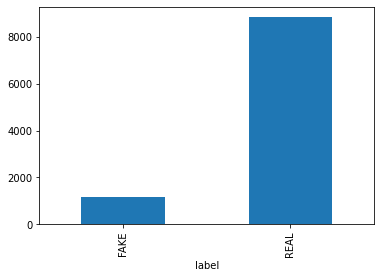

In [13]:
df.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [14]:
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

In [15]:
def tokenization(text):
    text = str(text)
    word = text.split()
    return word
df['text'] = df['text'].apply(tokenization)

In [16]:
def lowercase(word):
    new_word = list()
    for i in word:
        i = i.lower()
        new_word.append(i)
    return new_word
df['text'] = df['text'].apply(lowercase)

In [17]:
import string as s

def remove_punctuations(word):
    new_word = list() 
    for i in word:
        for j in s.punctuation:
            i = i.replace(j,'')
        new_word.append(i)
    return new_word
df['text'] = df['text'].apply(remove_punctuations)

In [18]:
def remove_stopwords(word):
    # to_remove = ['but','no', 'not','isn']
    # stop_words_ = set(stopwords.words('english')).difference(to_remove)
    stop_words_ = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're",
                 "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he',
                 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's",
                 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
                 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was',
                 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
                 'a', 'an', 'the', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by',
                 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above',
                 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
                 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
                 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than',
                 'too', 'very', 's', 't', 'can', 'will', 'just', 'should', "should've", 'now', 'd', 'll', 'm',
                 'o', 're', 've', 'y']
    new_word = list()
    for i in word:
        if i not in stop_words_:
            new_word.append(i)
    return new_word

df['text'] = df['text'].apply(remove_stopwords)

In [19]:
def remove_numbers(word):
    no_num_word = list()
    new_word = list()
    for i in word:
        for j in s.digits:    
            i = i.replace(j,'')
        no_num_word.append(i)
    for i in no_num_word:
        if i!='':
            new_word.append(i)
    return new_word
df['text'] = df['text'].apply(remove_numbers)

In [20]:
def remove_spaces(word):
    new_word = list()
    for i in word:
        i = i.strip()
        new_word.append(i)
    return new_word
df['text'] = df['text'].apply(remove_spaces)

In [21]:
df['text'] = df['text'].apply(lambda x: ''.join(i+' ' for i in x))

In [22]:
# change these to periods (nltk tokenizer uses periods to tokenize)
# and we really want to tokenize the hell out of the text
contra_words = ['however ','but ','although','nevertheless']
df['text'] = df['text'].str.replace('|'.join(contra_words), '. ')
# remove the words associated for when google translated a review
translated_terms = ['(translated google)', '(original)',
                    'translated by google''translate by google']
df['text'] = df['text'].str.replace('|'.join(translated_terms), ' ')

In [23]:
# replace punctuation with period
df['text'] = df['text'].apply(lambda x: re.sub('[^\w\s]', '. ', x))

In [24]:
# remove more than one space
df.text = df.text.replace('\s+', ' ', regex=True)

In [25]:
# remove all single characters
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x))

In [26]:
# remove non ascii (non english words)
def remove_non_ascii(text):
    return ''.join([i if ord(i) < 128 else ' ' for i in text])
df['text'] = df['text'].apply(remove_non_ascii)

In [27]:
def tokenize_eng_text(col):
   col = nltk.sent_tokenize(col)
   # col = ' '.join(col)
  #  print(col)
   return col
df['text'] = df['text'].apply(tokenize_eng_text)
# now remove periods (nltk tokenizes with periods)
df['text'] = df['text'].apply(lambda x: [y.replace('.', '') for y in x])

In [28]:
# explode dataframe using tokenized list
# create df to explode
df.reset_index(drop=True,inplace=True)
df['extra_id'] = df.index
dfe = df[['extra_id','text']]
print('exploding text')
dfe = dfe.explode('text')
print(dfe)
# clean up for outputting
# before merging - erase text columns on df
del df['text']
# join exploded df to original data
df = pd.merge(dfe, df, how='left', on='extra_id')

exploding text
      extra_id                                               text
0            0  food snack selection popular greek dishes appe...
1            1  little place soho wonderful lamb sandwich and ...
1            1            then soho staff little snotty and rude 
1            1          food great dont expect worldclass service
2            2  ordered lunch snack last friday   time nothing...
...        ...                                                ...
9998      9998                    theres always long wait brunch 
9998      9998          dont care food yummy service little slow 
9998      9998  foods always solid love handmade sodas drink w...
9999      9999                 wanted try place since moved city 
9999      9999  especially since lady obama dined past year   ...

[22472 rows x 2 columns]


In [29]:
# remove more than one space
dfe.text = dfe.text.replace('\s+', ' ', regex=True)
dfe = dfe[~pd.isnull(dfe['text'])]

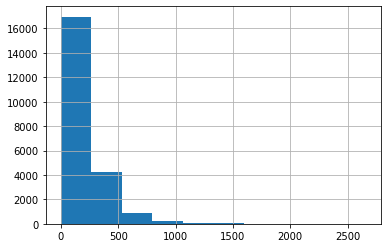

In [30]:
df['text'].str.len().hist()

In [31]:
df = df[pd.notnull(df['text'])]
df = df[df['text'].str.len() < 90]
df = df[df['text'].str.len() > 3]

In [32]:
df.head()

,extra_id,text,index,user_id,prod_id,date,rating,label,length,words,complexity
1,1,little place soho wonderful lamb sandwich and ...,1,924,0,2013-05-16,3.0,FAKE,52.0,"['this', 'little', 'place', 'in', 'soho', 'be'...",41.0
2,1,then soho staff little snotty and rude,1,924,0,2013-05-16,3.0,FAKE,52.0,"['this', 'little', 'place', 'in', 'soho', 'be'...",41.0
3,1,food great dont expect worldclass service,1,924,0,2013-05-16,3.0,FAKE,52.0,"['this', 'little', 'place', 'in', 'soho', 'be'...",41.0
12,8,tiny able stand waited and glass wine narrow b...,8,931,0,2005-12-27,4.0,FAKE,104.0,"['my', 'friend', 'and', 'i', 'be', 'intrigue',...",68.0
14,8,cinnamon overpowered flavors friend stuffed to...,8,931,0,2005-12-27,4.0,FAKE,104.0,"['my', 'friend', 'and', 'i', 'be', 'intrigue',...",68.0


In [33]:
df.reset_index(inplace=True)

In [34]:
df.drop(['index','extra_id','words'],axis=1, inplace=True)

In [35]:
df["num_words"] = df["text"].apply(lambda s: len(re.findall(r'\w+', s))) # Count the number of words in the message
df["message_len"] = df["text"].apply(len) # get the length of the text message

In [36]:
df.head()

,level_0,text,user_id,prod_id,date,rating,label,length,complexity,num_words,message_len
0,1,little place soho wonderful lamb sandwich and ...,924,0,2013-05-16,3.0,FAKE,52.0,41.0,13,85
1,2,then soho staff little snotty and rude,924,0,2013-05-16,3.0,FAKE,52.0,41.0,7,39
2,3,food great dont expect worldclass service,924,0,2013-05-16,3.0,FAKE,52.0,41.0,6,41
3,12,tiny able stand waited and glass wine narrow b...,931,0,2005-12-27,4.0,FAKE,104.0,68.0,12,77
4,14,cinnamon overpowered flavors friend stuffed to...,931,0,2005-12-27,4.0,FAKE,104.0,68.0,12,86


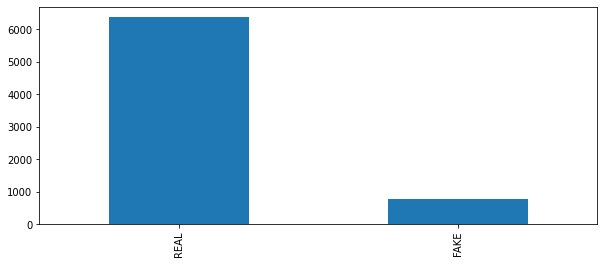

In [37]:
my_labels = ['FAKE','REAL']
plt.figure(figsize=(10,4))
df.label.value_counts().plot(kind='bar');

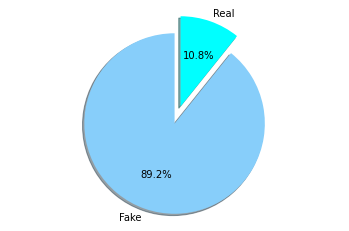

In [38]:
count_Class = pd.value_counts(df.label, sort = True)

# Data to Plot
labels = 'Fake', 'Real'
sizes = [count_Class[0], count_Class[1]]
colors = ['lightskyblue', 'aqua']
explode = (0.1, 0.1)

# Plot
plt.pie(sizes, explode = explode, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

In [59]:
df.head()

,level_0,text,user_id,prod_id,date,rating,label,length,complexity,num_words,message_len
0,1,little place soho wonderful lamb sandwich and ...,924,0,2013-05-16,3.0,FAKE,52.0,41.0,13,85
1,2,then soho staff little snotty and rude,924,0,2013-05-16,3.0,FAKE,52.0,41.0,7,39
2,3,food great dont expect worldclass service,924,0,2013-05-16,3.0,FAKE,52.0,41.0,6,41
3,12,tiny able stand waited and glass wine narrow b...,931,0,2005-12-27,4.0,FAKE,104.0,68.0,12,77
4,14,cinnamon overpowered flavors friend stuffed to...,931,0,2005-12-27,4.0,FAKE,104.0,68.0,12,86


In [39]:
!pip install transformers

     |████████████████████████████████| 890kB 8.5MB/s 
     |████████████████████████████████| 1.1MB 27.6MB/s 
     |████████████████████████████████| 890kB 60.6MB/s 
     |████████████████████████████████| 3.0MB 16.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c70db913b8f3845a535f592c274924af234efdd10d7de9734c7ffe0cca1238e6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [40]:
import torch
import transformers
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Loading DistilBERT

In [42]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

device = torch.device(dev)  

In [43]:
# Loading pretrained model/tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)

## Tokenizer
I will use DistillBERTTokenizer for this. This will separete the words in the sentence, add special tokens ("[CLS]" and "[SEP]") and replace every word for an ID

In [60]:
tokenized = df["text"].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
tokenized

0       [101, 2210, 2173, 23771, 6919, 12559, 11642, 1...
1       [101, 2059, 23771, 3095, 2210, 1055, 17048, 37...
2       [101, 2833, 2307, 2123, 2102, 5987, 2088, 2626...
3       [101, 4714, 2583, 3233, 4741, 1998, 3221, 4511...
4       [101, 21229, 2058, 27267, 26389, 2767, 11812, ...
                              ...                        
7136                         [101, 5925, 3829, 5024, 102]
7137    [101, 4895, 4168, 22122, 3468, 7852, 8458, 165...
7138    [101, 2045, 2015, 2467, 2146, 3524, 7987, 4609...
7139    [101, 2123, 2102, 2729, 2833, 9805, 18879, 232...
7140       [101, 2359, 3046, 2173, 2144, 2333, 2103, 102]
Name: text, Length: 7141, dtype: object

## Padding
Because the length of sentences is different, it is needed to padd them in order to make them same size

In [61]:
max_len = tokenized.apply(len).max() # get the length of the longest tokenized sentence

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) # padd the rest of the sentence with zeros if the sentence is smaller than the longest sentence
padded

array([[  101,  2210,  2173, ...,     0,     0,     0],
       [  101,  2059, 23771, ...,     0,     0,     0],
       [  101,  2833,  2307, ...,     0,     0,     0],
       ...,
       [  101,  2045,  2015, ...,     0,     0,     0],
       [  101,  2123,  2102, ...,     0,     0,     0],
       [  101,  2359,  3046, ...,     0,     0,     0]])

But now since we've added these zeros we'll have to create another matrix in which to tell BERT what should it pay attention and what should it ignore. Everything that is a zero we tell BERT to ignore it

In [62]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

Finally we can send our input data to BERT to get the classification embeddings for the messages

In [63]:
input_ids = torch.tensor(padded).to(device)  # create a torch tensor for the padded sentences
attention_mask = torch.tensor(attention_mask).to(device) # create a torch tensor for the attention matrix

In [64]:
with torch.no_grad():
  encoder_hidden_state = model(input_ids, attention_mask=attention_mask)

The first element in encoder_hidden_state is the one we want. This matrix is of shape (number_of_sentences, max_sentence_length, 768). From this matrix we are only interested in the first column of every row, which is the column with the "[CLS]" embedding, the embedding used for classification

In [72]:
X = encoder_hidden_state[0][:,0,:].cpu().numpy()
X = np.hstack((X, df[["num_words", "message_len"]].to_numpy().reshape(-1, 2))) # addind the the engineered features from the beginning
y = df["label"]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Exploratory Data Analysis
We'll use T-SNE to reduce the dimensions in the data down to just 2 so we can plot them

In [74]:
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_train)
X_embedded.shape

(5355, 2)

In [79]:
# creating the dataframe for plotting
def creat_plotting_data(data, labels=y_train):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["label"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2", 768:"num_words", 769: "message_len"}, axis=1, inplace=True)
    return df

# creating the dataframes for plotting
plotting_data = creat_plotting_data(X_train)
plotting_data_embedded = creat_plotting_data(X_embedded)

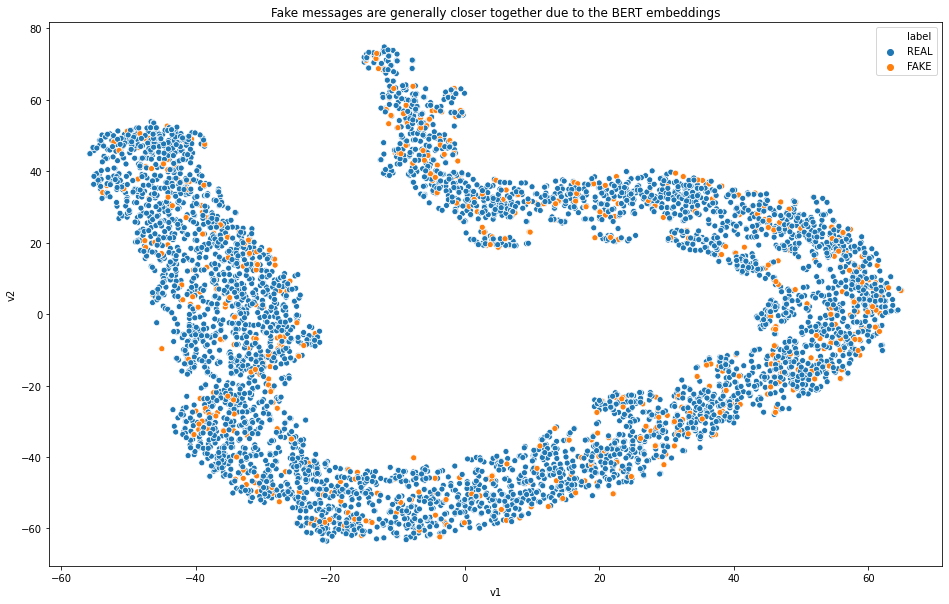

In [82]:
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="label", data=plotting_data_embedded)
ax.set(title = "Fake messages are generally closer together due to the BERT embeddings")
plt.show()

Each point in this plot represents a sentence that is colorized according to it being fake or not. This shows us that the embeddings that BERT created have succesfully encoded our data in such a way that fake massages are all closer together.

Some outliers exist but it may be due to the embedding being based on only 10 tokens or just so really good fake massages.

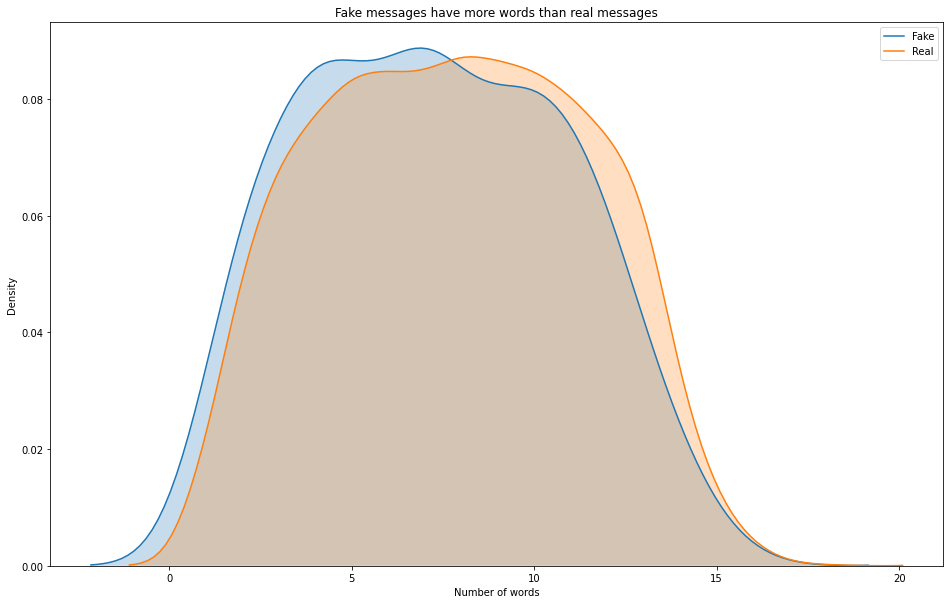

In [84]:
f,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(plotting_data.loc[plotting_data.label == "FAKE", "num_words"], shade=True, label="Fake")
sns.kdeplot(plotting_data.loc[plotting_data.label == "REAL", "num_words"], shade=True, label="Real", clip=(0, 35)) # removing observations with message length above 35 because there is an outlier
ax.set(xlabel = "Number of words", ylabel = "Density",title = "Fake messages have more words than real messages")
plt.show()

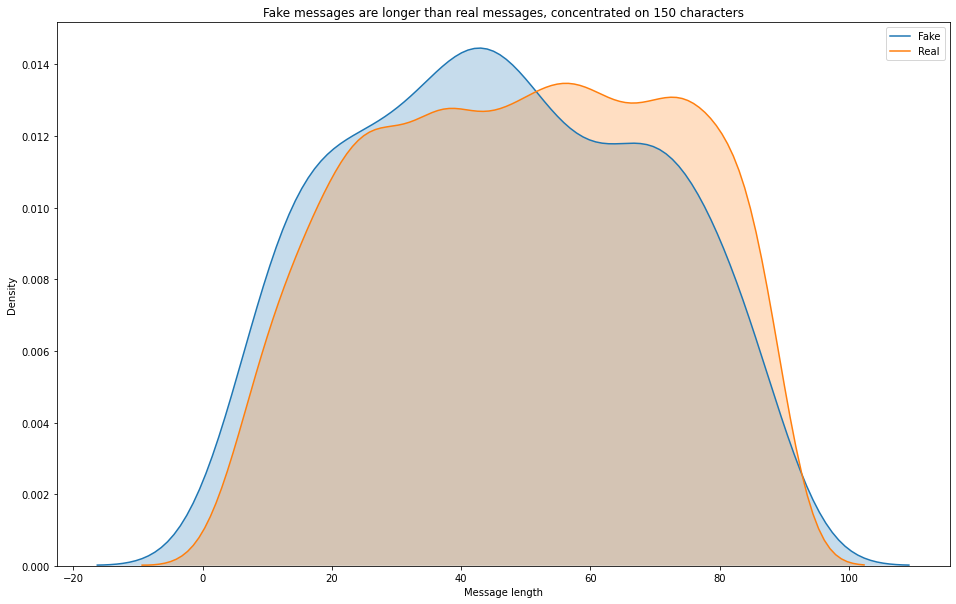

In [85]:
f,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(plotting_data.loc[plotting_data.label == "FAKE", "message_len"], shade=True, label="Fake")
sns.kdeplot(plotting_data.loc[plotting_data.label == "REAL", "message_len"], shade=True, label="Real", clip=(0, 250)) # removing observations with message length above 250 because there is an outlier
ax.set(xlabel = "Message length", ylabel = "Density",title = "Fake messages are longer than real messages, concentrated on 150 characters")
plt.show()

# Let's build the model

## Random Forest

In [86]:
rf_classifier = RandomForestClassifier(n_estimators=1500, class_weight="balanced", n_jobs=-1, random_state=42) # Create a baseline random forest (no cross-validation, no hyperparameter tuning)
rf_classifier.fit(X_train, y_train)
preds = rf_classifier.predict(X_test)

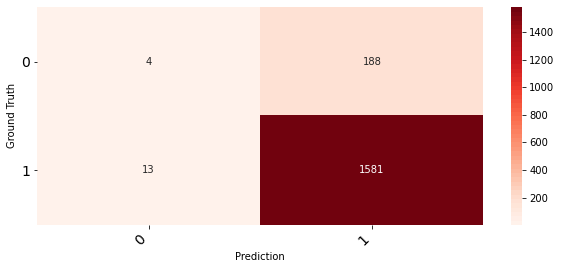

In [87]:
fig = plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

In [89]:
# print(f"""Accuray: {round(accuracy_score(y_test, preds), 5) * 100}%
# ROC-AUC: {round(roc_auc_score(y_test, preds), 5) * 100}%""")
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        FAKE       0.24      0.02      0.04       192
        REAL       0.89      0.99      0.94      1594

    accuracy                           0.89      1786
   macro avg       0.56      0.51      0.49      1786
weighted avg       0.82      0.89      0.84      1786

